# From LSM to MLM (...a.k.a. from Physics 1 laboratory to the Likelihood)

This notebook should clarify how to move from the typical Physics-1 lab Least Square Method fit,  where we consider noisy measurements (uncertainties) in y and no uncertainties in x, to the corresponding fit with a Maximum Likelihood Method.

**Ohm\'s law:**

One physical example that you can keep in mind would be the measurement of a resistance by setting different voltages (no uncertainties) and measuring the corresponding current affected by a gaussian noise.


### Produce the data
First of all we produce the data common for both approaches

You're modeling Ohm’s Law: I = V / R \
True resistance  R = 1 $\Omega$ \
Voltage: 10 points, 1V to 10V, equally spaced \
Current: I =V / 1 $\Omega$  \
Current uncertainty: gaussian noise of 0.2 A

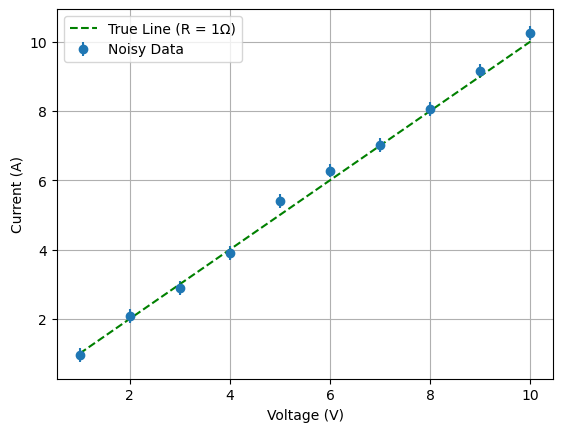

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(12345)

# Generate data
R_true = 1.0  # Ohms
V = np.linspace(1, 10, 10)
I_true = V / R_true
sigma_I = 0.2
I_measured = np.random.normal(loc=I_true, scale=sigma_I)
I_uncertainty = np.full_like(I_measured, sigma_I)
weights = 1 / I_uncertainty**2

# Plot
plt.errorbar(V, I_measured, yerr=I_uncertainty, fmt='o', label='Noisy Data')
plt.plot(V, I_true, 'g--', label='True Line (R = 1Ω)')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.legend()
plt.grid(True)
plt.show()

### LSM fit

Iter    0: chi2 = 2165.7905, m = 1.4450, b = 3.3245e-01
Iter   10: chi2 = 1055.4263, m = 1.3087, b = 2.8186e-01
Iter   20: chi2 = 516.2069, m = 1.2146, b = 2.4044e-01
Iter   30: chi2 = 254.2503, m = 1.1499, b = 2.0604e-01
Iter   40: chi2 = 126.9102, m = 1.1055, b = 1.7707e-01
Iter   50: chi2 = 64.9441, m = 1.0752, b = 1.5239e-01
Iter   60: chi2 = 34.7381, m = 1.0547, b = 1.3115e-01
Iter   70: chi2 = 19.9717, m = 1.0409, b = 1.1271e-01
Iter   80: chi2 = 12.7191, m = 1.0318, b = 9.6583e-02
Iter   90: chi2 = 9.1296, m = 1.0259, b = 8.2401e-02
Iter  100: chi2 = 7.3312, m = 1.0221, b = 6.9868e-02
Iter  110: chi2 = 6.4129, m = 1.0199, b = 5.8749e-02
Iter  120: chi2 = 5.9303, m = 1.0186, b = 4.8854e-02
Iter  130: chi2 = 5.6662, m = 1.0180, b = 4.0027e-02
Iter  140: chi2 = 5.5139, m = 1.0178, b = 3.2139e-02
Iter  150: chi2 = 5.4204, m = 1.0179, b = 2.5077e-02
Iter  160: chi2 = 5.3591, m = 1.0182, b = 1.8749e-02
Iter  170: chi2 = 5.3166, m = 1.0186, b = 1.3073e-02
Iter  180: chi2 = 5.2855, m = 

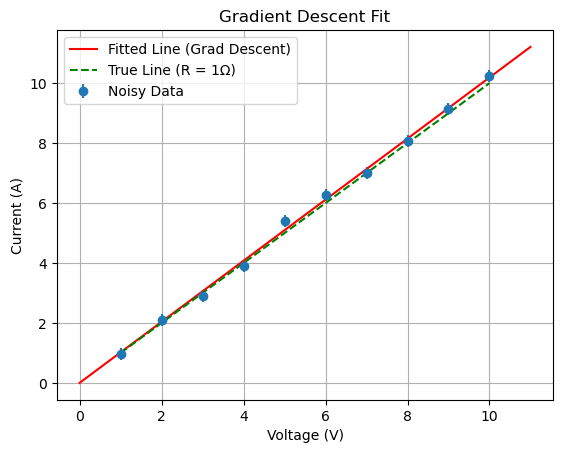

In [6]:
# Chi-squared function
def chi_squared(m, b):
    model = m * V + b
    chi2 = np.sum(((I_measured - model) / I_uncertainty) ** 2)
    return chi2

# Gradients of chi-squared
def gradients(m, b):
    model = m * V + b
    residuals = I_measured - model
    dchi2_dm = -2 * np.sum((residuals * V) * weights)
    dchi2_db = -2 * np.sum(residuals * weights)
    return dchi2_dm, dchi2_db

# Gradient descent parameters
m = 0.5  # Initial guess
b = 0.2  # Initial guess
learning_rate = 0.0001
n_iterations = 200

# Gradient descent loop
for i in range(n_iterations):
    dchi2_dm, dchi2_db = gradients(m, b)
    m -= learning_rate * dchi2_dm
    b -= learning_rate * dchi2_db
    if i % 10 == 0 or i == n_iterations - 1:
        chi2 = chi_squared(m, b)
        print(f"Iter {i:4d}: chi2 = {chi2:.4f}, m = {m:.4f}, b = {b:.4e}")

# Calculate resistance
R_fit = 1 / m
print(f"\nGradient Descent Result:")
print(f"Fitted slope (1/R): {m:.4f} 1/Ohm")
print(f"Fitted intercept: {b:.4e} A")
print(f"Estimated resistance R_fit: {R_fit:.4f} Ohm")

# Plot
plt.errorbar(V, I_measured, yerr=I_uncertainty, fmt='o', label='Noisy Data')
V_fit = np.linspace(0, 11, 100)
plt.plot(V_fit, m * V_fit + b, 'r-', label='Fitted Line (Grad Descent)')
plt.plot(V, I_true, 'g--', label='True Line (R = 1Ω)')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.title('Gradient Descent Fit')
plt.legend()
plt.grid(True)
plt.show()

### MLM fit
Now we repeat the fit using the Maximum Likelihood Method:

Iter    0: NLL = -1.4636, m = 0.9725, b = 2.6622e-01
Iter  199: NLL = -4.0131, m = 1.0094, b = 6.9492e-02

Maximum Likelihood Fit Results:
Fitted slope (1/R): 1.0094 1/Ohm
Fitted intercept: 6.9492e-02 A
Estimated resistance R_fit: 0.9906 Ohm


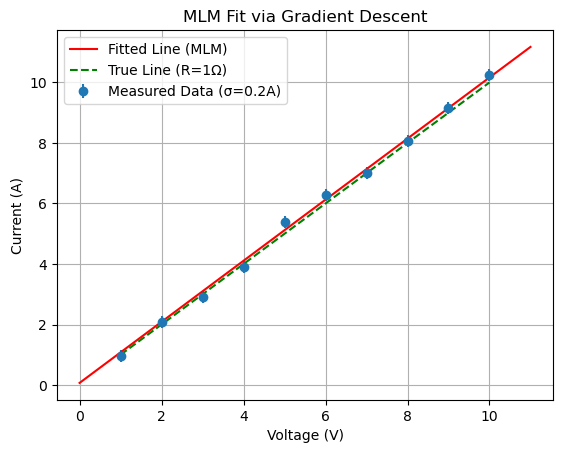

In [7]:
def negative_log_likelihood(m, b):
    model = m * V + b
    residuals = I_measured - model
    nll = 0.5 * np.sum((residuals / sigma_I)**2) + len(V) * np.log(np.sqrt(2 * np.pi) * sigma_I)
    return nll

def gradients_nll(m, b):
    model = m * V + b
    residuals = I_measured - model
    dNLL_dm = -np.sum(residuals * V) / sigma_I**2
    dNLL_db = -np.sum(residuals) / sigma_I**2
    return dNLL_dm, dNLL_db

# Gradient descent parameters
m = 0.5  # Initial guess
b = 0.2  # Initial guess
learning_rate = 0.0001
n_iterations = 200

# Gradient descent loop
for i in range(n_iterations):
    dNLL_dm, dNLL_db = gradients_nll(m, b)
    m -= learning_rate * dNLL_dm
    b -= learning_rate * dNLL_db
    if i % 500 == 0 or i == n_iterations - 1:
        nll = negative_log_likelihood(m, b)
        print(f"Iter {i:4d}: NLL = {nll:.4f}, m = {m:.4f}, b = {b:.4e}")

R_fit = 1 / m
print("\nMaximum Likelihood Fit Results:")
print(f"Fitted slope (1/R): {m:.4f} 1/Ohm")
print(f"Fitted intercept: {b:.4e} A")
print(f"Estimated resistance R_fit: {R_fit:.4f} Ohm")

plt.errorbar(V, I_measured, yerr=I_uncertainty, fmt='o', label='Measured Data (σ=0.2A)')
V_fit = np.linspace(0, 11, 100)
plt.plot(V_fit, m * V_fit + b, 'r-', label='Fitted Line (MLM)')
plt.plot(V, I_true, 'g--', label='True Line (R=1Ω)')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.title('MLM Fit via Gradient Descent')
plt.legend()
plt.grid(True)
plt.show()
